Epoch 1, Loss: 0.1510
Epoch 2, Loss: 0.0742
Epoch 3, Loss: 0.0664
Epoch 4, Loss: 0.0637
Epoch 5, Loss: 0.0608
Epoch 6, Loss: 0.0583
Epoch 7, Loss: 0.0603
Epoch 8, Loss: 0.0576
Epoch 9, Loss: 0.0597
Epoch 10, Loss: 0.0562
Epoch 11, Loss: 0.0570
Epoch 12, Loss: 0.0595
Epoch 13, Loss: 0.0559
Epoch 14, Loss: 0.0553
Epoch 15, Loss: 0.0539
Epoch 16, Loss: 0.0560
Epoch 17, Loss: 0.0577
Epoch 18, Loss: 0.0532
Epoch 19, Loss: 0.0564
Epoch 20, Loss: 0.0549


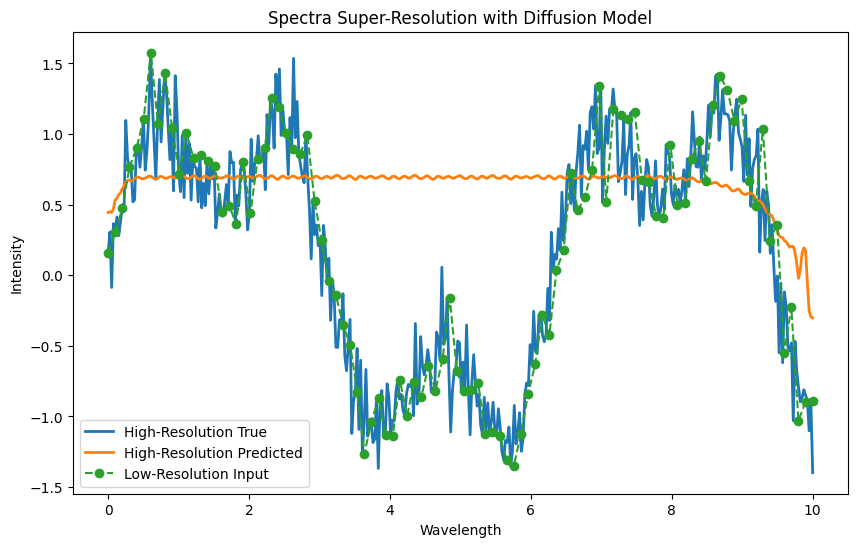

In [ ]:
import torchcd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt


class SpectraDataset(Dataset):
    def __init__(self, low_res, high_res):
        self.low_res = low_res
        self.high_res = high_res

    def __len__(self):
        return len(self.low_res)

    def __getitem__(self, idx):
        return torch.tensor(self.low_res[idx], dtype=torch.float32), torch.tensor(self.high_res[idx], dtype=torch.float32)


class DiffusionSpectraModel(nn.Module):
    def __init__(self, time_steps=1000):
        super(DiffusionSpectraModel, self).__init__()
        self.time_steps = time_steps
        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=5, padding=2)
        )

    def forward(self, x, t):
        t_emb = torch.sin(t.unsqueeze(-1).unsqueeze(-1) * torch.arange(1, x.shape[-1] + 1, device=x.device))
        x = x + t_emb
        return self.model(x)

def generate_synthetic_data(num_samples=1000, low_res_points=100, high_res_points=400):
    low_res_data = []
    high_res_data = []
    for _ in range(num_samples):
        x = np.linspace(0, 10, high_res_points)
        spectrum = np.sin(x) + 0.5 * np.sin(3 * x) + 0.2 * np.random.randn(high_res_points)
        low_res = spectrum[::high_res_points // low_res_points]
        low_res_data.append(low_res)
        high_res_data.append(spectrum)
    return np.array(low_res_data), np.array(high_res_data)

# Generate and prepare data
low_res, high_res = generate_synthetic_data()
dataset = SpectraDataset(low_res, high_res)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionSpectraModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(20):
    epoch_loss = 0
    for lr_spec, hr_spec in dataloader:
        lr_spec = lr_spec.unsqueeze(1).to(device)
        hr_spec = hr_spec.unsqueeze(1).to(device)
        lr_spec_up = torch.nn.functional.interpolate(lr_spec, size=hr_spec.shape[-1], mode="linear", align_corners=False)
        t = torch.randint(0, model.time_steps, (lr_spec_up.shape[0],), device=device).float()
        optimizer.zero_grad()
        output = model(lr_spec_up, t)
        loss = criterion(output, hr_spec)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader):.4f}")

# Evaluate the model
model.eval()
test_lr, test_hr = generate_synthetic_data(num_samples=1)
test_lr_tensor = torch.tensor(test_lr, dtype=torch.float32).unsqueeze(1).to(device)
test_lr_up = torch.nn.functional.interpolate(test_lr_tensor, size=high_res.shape[-1], mode="linear", align_corners=False)
y_pred = test_lr_up.clone()
for t in reversed(range(model.time_steps)):
    t_tensor = torch.full((y_pred.shape[0],), t, device=device, dtype=torch.float32)
    y_pred = model(y_pred, t_tensor)
predicted_hr = y_pred.detach().cpu().numpy().squeeze()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 10, len(test_hr[0])), test_hr[0], label="High-Resolution True", linewidth=2)
plt.plot(np.linspace(0, 10, len(predicted_hr)), predicted_hr, label="High-Resolution Predicted", linewidth=2)
plt.plot(np.linspace(0, 10, len(test_lr[0])), test_lr[0], label="Low-Resolution Input", linestyle='--', marker='o')
plt.legend()
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Spectra Super-Resolution with Diffusion Model")
plt.show()
